In [1]:
#import setGPU
import os
import numpy as np
import h5py
import glob
import itertools
import sys
from sklearn.utils import shuffle
import glob

In [2]:
datasets = [np.array([]), np.array([]), np.array([]), np.array([])]
dataNames = ["genJetConstituents", "recoJetConstituents", "genJetFeatures", "recoJetFeatures"]
for fileIN in glob.glob("../data/*h5"):
    f = h5py.File(fileIN,"r")
    for i in range(4):
        mydata = f.get(dataNames[i])
        datasets[i] = np.concatenate((datasets[i], mydata), axis=0) if datasets[i].size else mydata
genJetParticles = datasets[0]
recoJetParticles = datasets[1]
genJet = datasets[2]
recoJet = datasets[3]
print(genJetParticles.shape, recoJetParticles.shape, genJet.shape, recoJet.shape)

(109984, 100, 3) (109984, 100, 3) (109984, 4) (109984, 4)


In [3]:
# dirty trick: the target is a vector of zeros
y = np.zeros(genJetParticles.shape[0])
print(y.shape)

(109984,)


In [4]:
# add the "noisy" latent space variables to the genjet dataset
rndVars = np.random.normal(0., 1., (genJet.shape[0],10))
print(rndVars.shape)
genJet = np.concatenate((genJet,rndVars), axis =1)
print(genJet.shape)

(109984, 10)
(109984, 14)


In [40]:
# keras imports
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Conv2D, Dropout, Flatten, Concatenate, Reshape, BatchNormalization, Activation, Lambda
from keras.layers import AveragePooling2D, Add, Multiply, LeakyReLU
from keras.utils import plot_model
from keras import regularizers
from keras import backend as K
from keras import metrics
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [6]:
# import the EMD model
from keras.models import model_from_json
json_file = open('../models/EMD_Dense_MAE_AsymmetryLarge_1.json')
loaded_model_json = json_file.read()
json_file.close()
emdModel = model_from_json(loaded_model_json)
# load weights into new model
emdModel.load_weights("../models/EMD_Dense_MAE_AsymmetryLarge_1.h5")
print("Loaded model from disk")
for l in emdModel.layers: 
    l.trainable=False
emdModel.summary()

W0805 14:18:22.739948 4671862208 deprecation_wrapper.py:119] From /Users/maurizio/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 14:18:22.768321 4671862208 deprecation_wrapper.py:119] From /Users/maurizio/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 14:18:22.769136 4671862208 deprecation_wrapper.py:119] From /Users/maurizio/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0805 14:18:22.769850 4671862208 deprecation_wrapper.py:119] From /Users/maurizio/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProt

Loaded model from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 6, 1)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 6, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 6, 1)          6010      
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 6, 1)          4         
_________________________________________________________________
activation_1 (Activation)    (None, 10, 6, 1)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 6, 1)           505       
_________________________________________________________________
batch_normalization_3 (Batch (None, 5, 6, 1)         

In [22]:
inputGensize = genJet.shape[1]
nParticles = genJetParticles.shape[1]

# Jet Gen model

In [56]:
# the reco jet
inputRecoImage = Input(shape=(nParticles,3))
xReco = Reshape((100,3,1))(inputRecoImage)

# convert the input gen info into an array of "structured" noise
inputGenJet = Input(shape=(inputGensize,))
x = BatchNormalization(name='noise1')(inputGenJet)
x = Dense(nParticles, activation="relu",name='noise2')(x)
x = Dense(nParticles*3, activation="relu",name='noise3')(x)
StrucNoise = Reshape((nParticles,3),name='noise4')(x)

# concatenate the input gen image to the structured noise
inputGenImage = Input(shape=(nParticles,3))
x = Concatenate(axis=-1,name='gen3')([inputGenImage,StrucNoise])
x = Reshape((nParticles,6,1),name='gen4')(x)
x = BatchNormalization()(x)

# process the image and produce the output
pTCorr = Conv2D(1, kernel_size=(3,6), strides=(1, 6), name = "pT", data_format="channels_last", padding="same", activation="sigmoid")(x)
pTCorr = Dropout(0.2)(pTCorr)
#pTCorr = LeakyReLU(alpha=0.1)(pTCorr)
pTCorr = Reshape((100,1))(pTCorr)
pT = Lambda(lambda x: x[:,:,0])(inputGenImage)
pT = Reshape((100,1))(pT)
pT = Add()([pT, pTCorr])
#pT = Activation("elu")(pT)

etaCorr = Conv2D(1, kernel_size=(3,6), strides=(1, 6), name = "eta", data_format="channels_last", padding="same")(x)
etaCorr = Dropout(0.2)(etaCorr)
etaCorr = LeakyReLU(alpha=0.1)(etaCorr)
etaCorr = Reshape((100,1))(etaCorr)
eta = Lambda(lambda x: x[:,:,1])(inputGenImage)
eta = Reshape((100,1))(eta)
eta = Add()([eta, etaCorr])
eta = Activation("tanh")(eta)
eta = Lambda(lambda x: x*0.8)(eta)

phiCorr = Conv2D(1, kernel_size=(3,6), strides=(1, 6), name = "phi", data_format="channels_last", padding="same")(x)
phiCorr = Dropout(0.2)(phiCorr)
phiCorr = LeakyReLU(alpha=0.1)(phiCorr)
phiCorr = Reshape((100,1))(phiCorr)
phi = Lambda(lambda x: x[:,:,2])(inputGenImage)
phi = Reshape((100,1))(phi)
phi = Add()([phi, phiCorr])
phi = Activation("tanh")(phi)
phi = Lambda(lambda x: x*0.8)(phi)

outGen = Concatenate(axis=-1)([pT,eta,phi])
x = Reshape((100,3,1))(outGen)

x = Concatenate(axis=-2)([x,xReco])

out = emdModel(x)

model = Model(inputs=(inputRecoImage,inputGenJet,inputGenImage), outputs=out)
generator = Model(inputs=(inputGenJet,inputGenImage), outputs=outGen)

In [57]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

In [58]:
# dirty trick: if the target is a vector of zeros, mae gives the average score (which is what we want)
model.compile(optimizer='adam', loss='mae')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 14)           0                                            
__________________________________________________________________________________________________
noise1 (BatchNormalization)     (None, 14)           56          input_20[0][0]                   
__________________________________________________________________________________________________
noise2 (Dense)                  (None, 100)          1500        noise1[0][0]                     
__________________________________________________________________________________________________
noise3 (Dense)                  (None, 300)          30300       noise2[0][0]                     
__________________________________________________________________________________________________
input_21 (

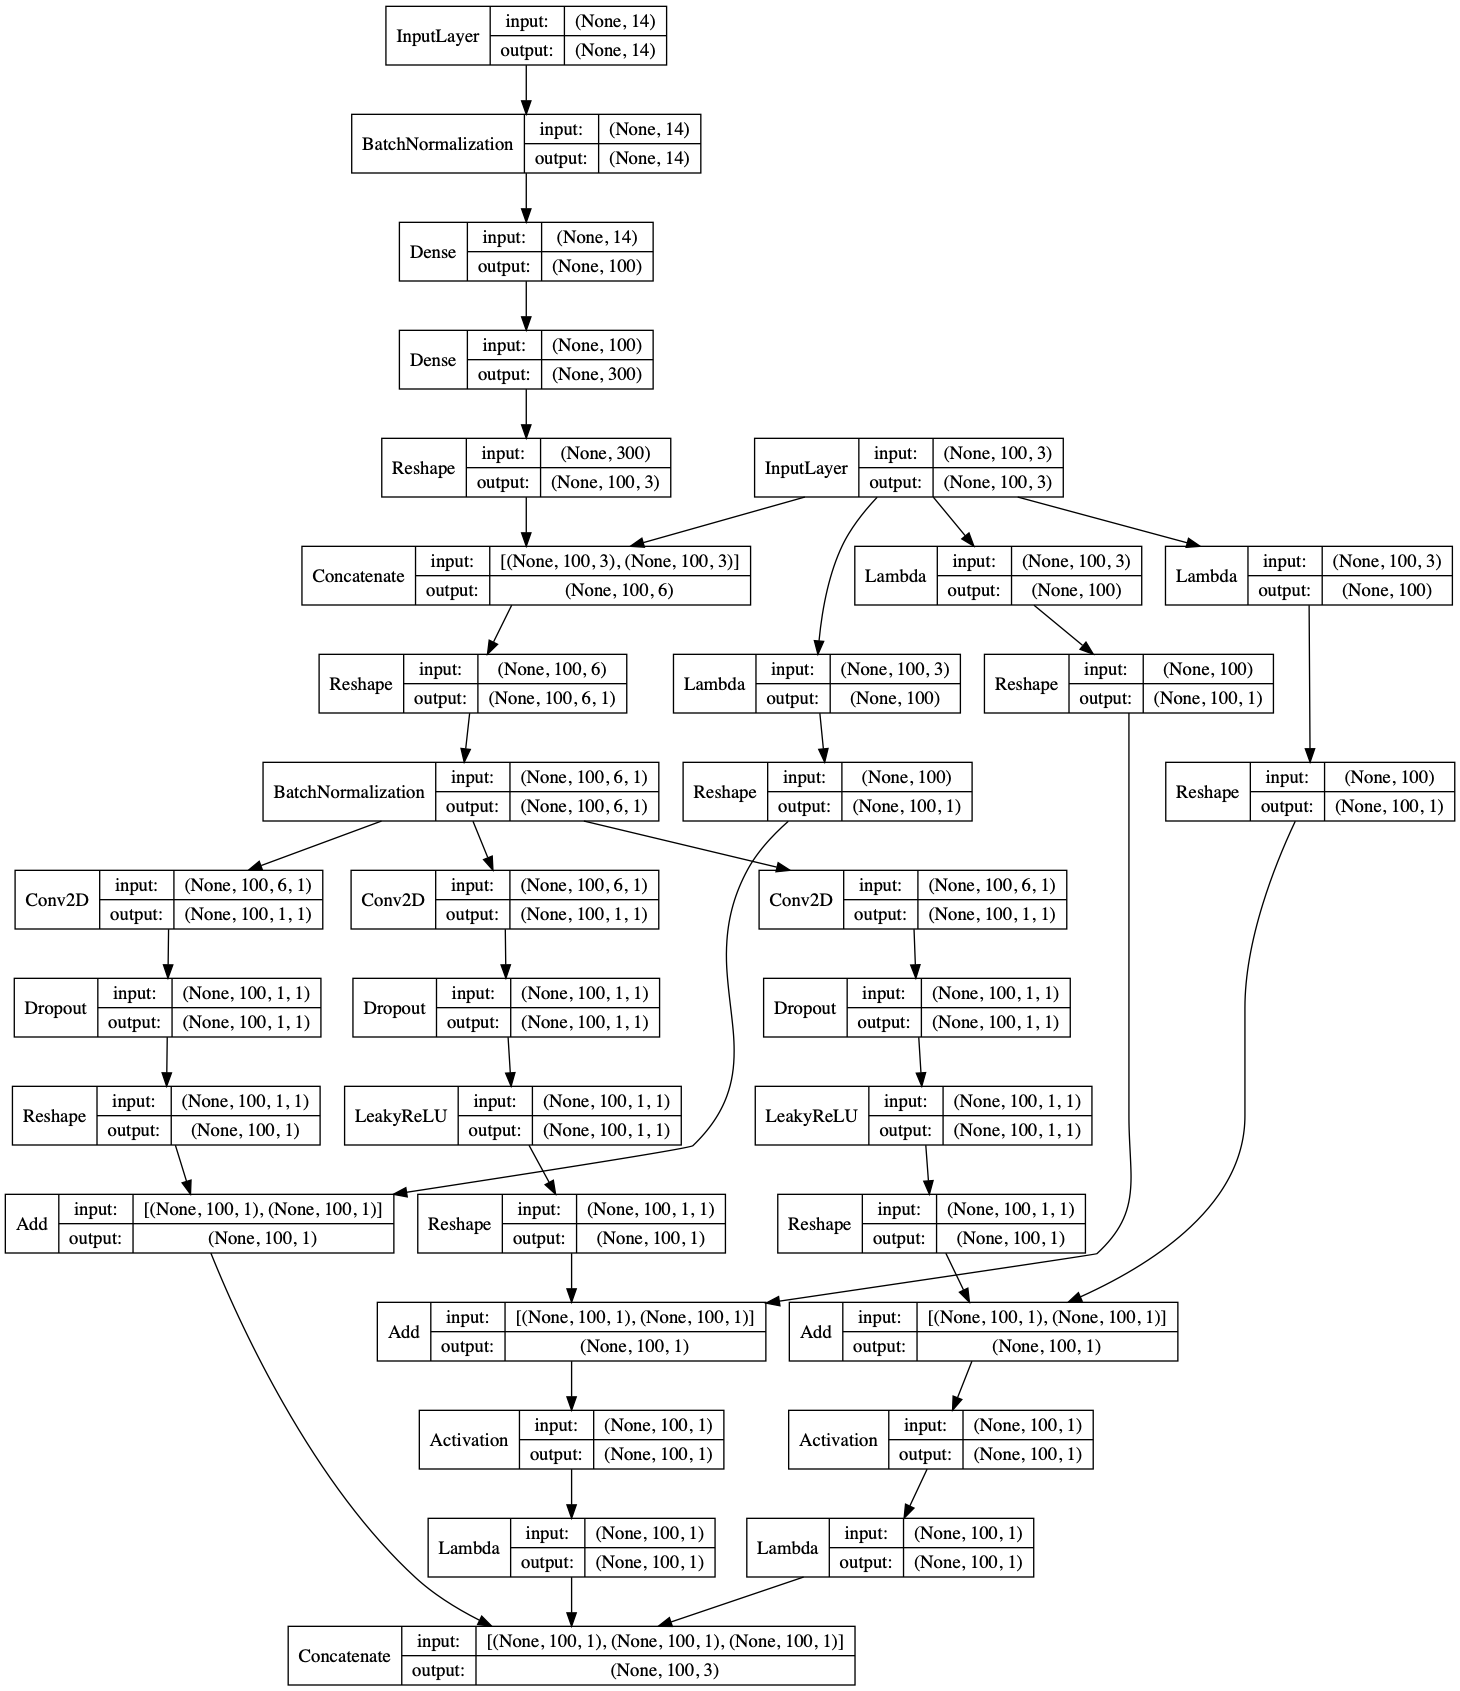

In [59]:
generator.summary()
plot_model(generator, to_file='../models/generator.png', show_shapes=True, show_layer_names=False)
Image(retina=True, filename='../models/generator.png')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 14)           0                                            
__________________________________________________________________________________________________
noise1 (BatchNormalization)     (None, 14)           56          input_20[0][0]                   
__________________________________________________________________________________________________
noise2 (Dense)                  (None, 100)          1500        noise1[0][0]                     
__________________________________________________________________________________________________
noise3 (Dense)                  (None, 300)          30300       noise2[0][0]                     
__________________________________________________________________________________________________
input_21 (

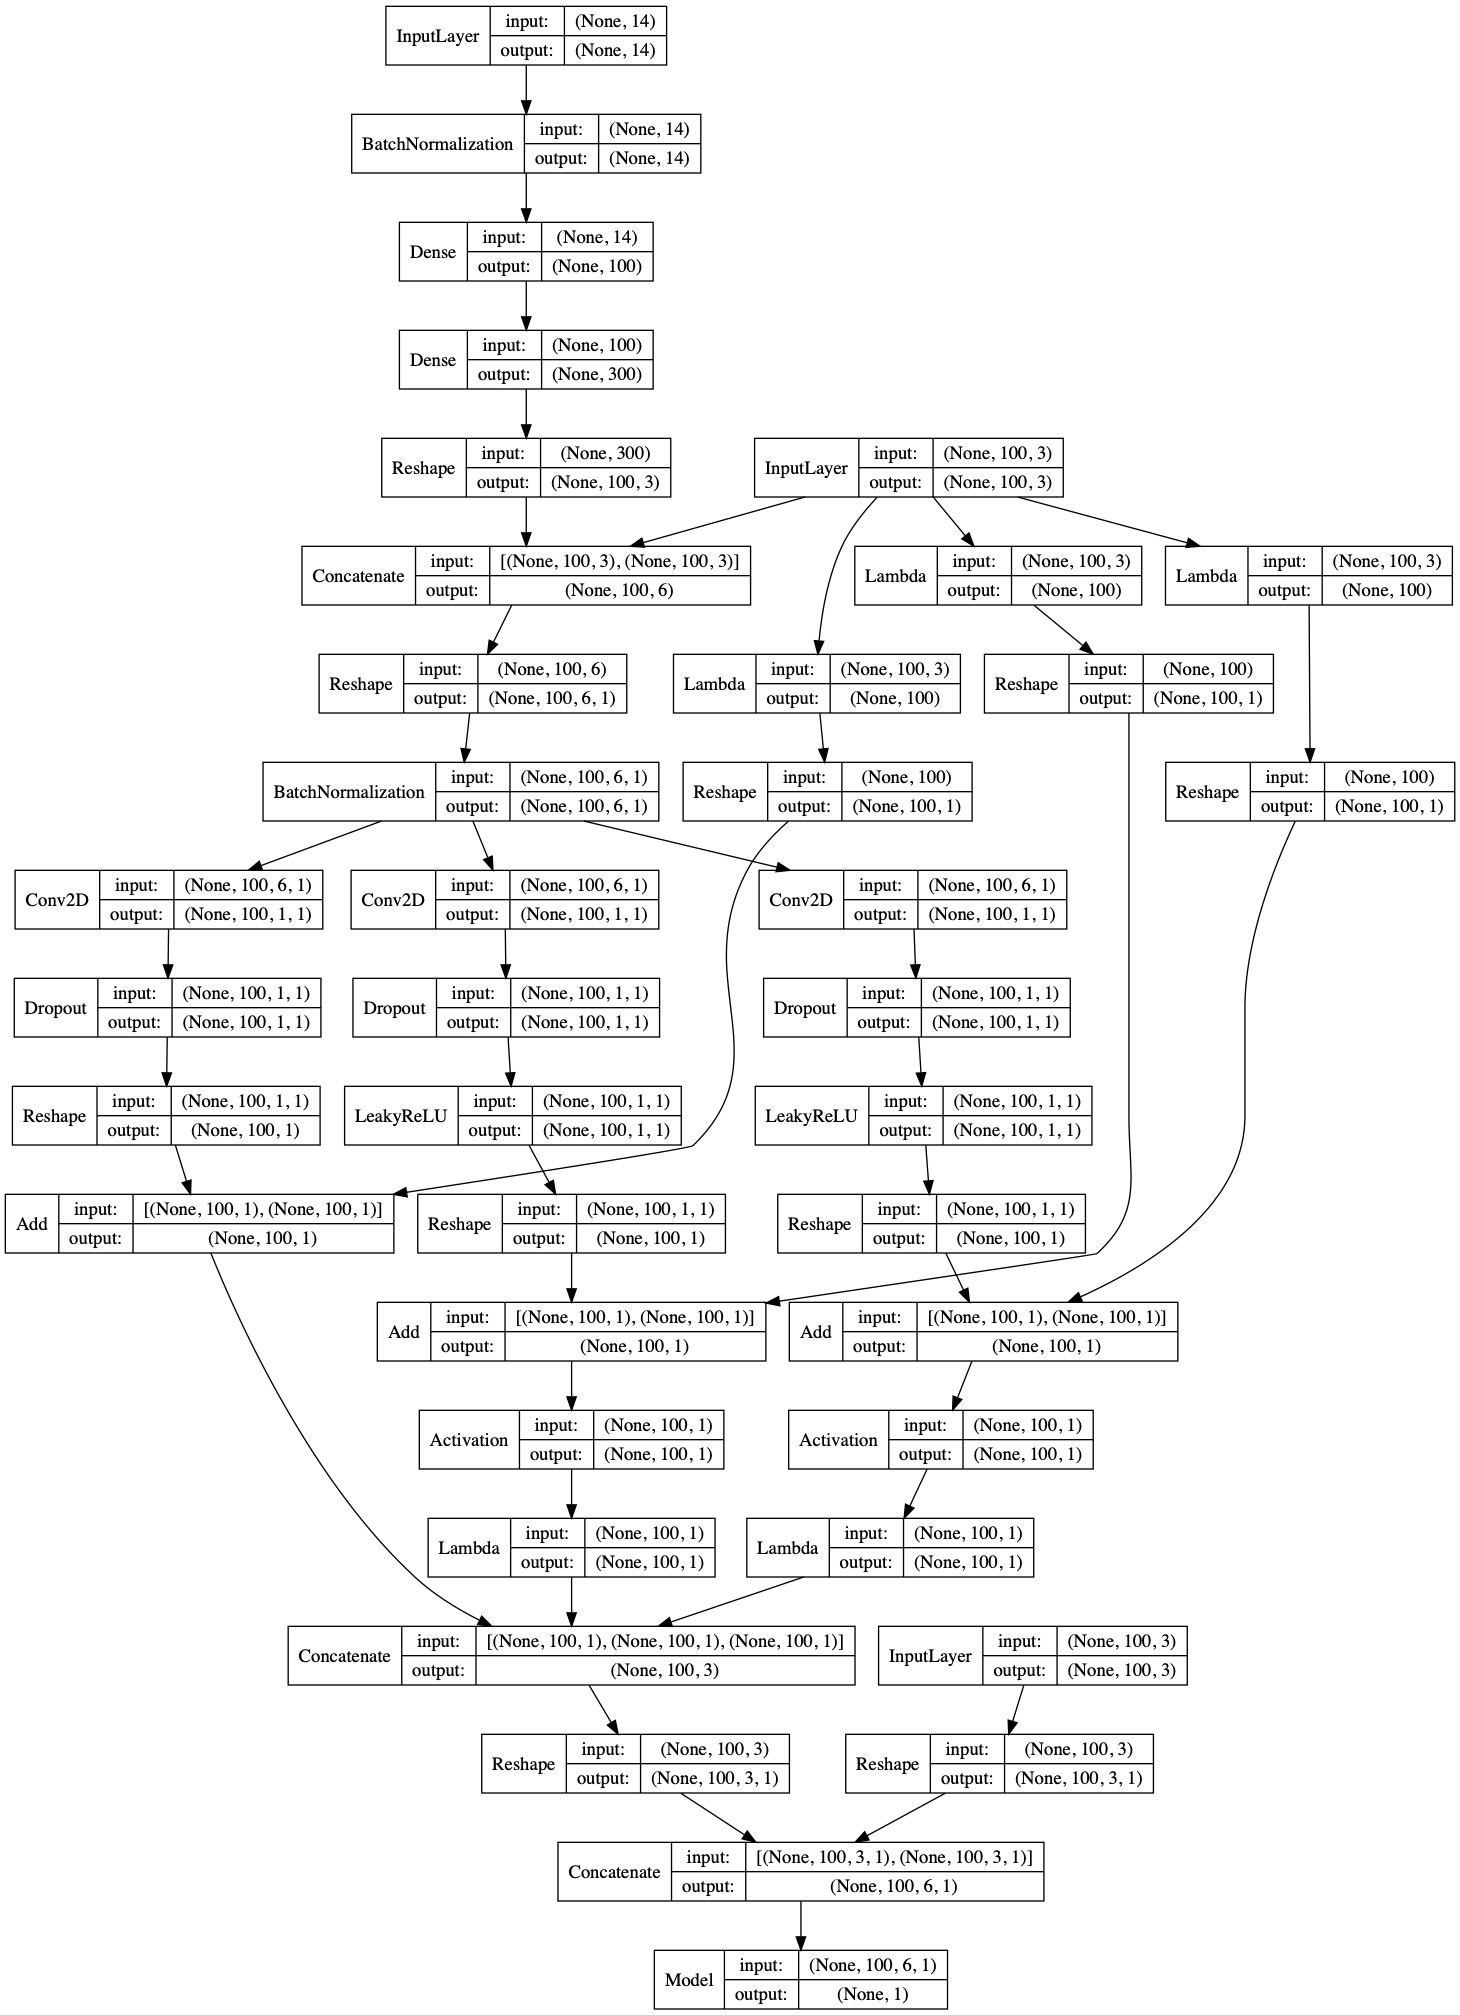

In [60]:
model.summary()
plot_model(model, to_file='../models/full_model.png', show_shapes=True, show_layer_names=False)
Image(retina=True, filename='../models/full_model.png')

In [63]:
# fit the model
history = model.fit([recoJetParticles, genJet, genJetParticles], y, epochs=500, batch_size=128, verbose = 1,
                  validation_split = 0.3, callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Train on 76988 samples, validate on 32996 samples
Epoch 1/500
76988/76988 [==============================] - 15s 195us/step - loss: 191.7502 - val_loss: 226.8722
Epoch 2/500
76988/76988 [==============================] - 13s 163us/step - loss: 189.7957 - val_loss: 226.1014
Epoch 3/500
76988/76988 [==============================] - 13s 166us/step - loss: 189.2852 - val_loss: 227.0815
Epoch 4/500
76988/76988 [==============================] - 13s 164us/step - loss: 188.9374 - val_loss: 227.6848

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/500
76988/76988 [==============================] - 13s 164us/step - loss: 188.7962 - val_loss: 227.8098
Epoch 6/500
76988/76988 [==============================] - 13s 165us/step - loss: 188.7518 - val_loss: 227.9950

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 7/500
76988/76988 [==============================] - 13s 166us/step - loss: 188.7429 - val_loss: 227.9582
Ep

In [64]:
nameModel = 'JetGen_EMD'
# store history                                                                                                         
f = h5py.File("../models/%s_history.h5" %nameModel, "w")
f.create_dataset("training_loss", data=np.array(history.history['loss']),compression='gzip')
f.create_dataset("validation_loss", data=np.array(history.history['val_loss']),compression='gzip')
f.close()

# store model                                                                                                           
model_json = generator.to_json()
with open("../models/%s_GENERATOR.json" %nameModel, "w") as json_file:
    json_file.write(model_json)
generator.save_weights("../models/%s_GENERATOR.h5" %nameModel)

# store full model                                                                                                           
model_json = model.to_json()
with open("../models/%s.json" %nameModel, "w") as json_file:
    json_file.write(model_json)
model.save_weights("../models/%s.h5" %nameModel)

In [61]:
# fit the model
generator.compile(optimizer='adam', loss='mae')
history = generator.fit([genJet, genJetParticles], recoJetParticles, epochs=500, batch_size=128, verbose = 1,
                  validation_split = 0.3, callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Train on 76988 samples, validate on 32996 samples
Epoch 1/500
76988/76988 [==============================] - 10s 134us/step - loss: 2.3486 - val_loss: 2.3082
Epoch 2/500
76988/76988 [==============================] - 8s 102us/step - loss: 2.3274 - val_loss: 2.3015
Epoch 3/500
76988/76988 [==============================] - 8s 102us/step - loss: 2.3213 - val_loss: 2.2955
Epoch 4/500
76988/76988 [==============================] - 8s 102us/step - loss: 2.3169 - val_loss: 2.2900
Epoch 5/500
76988/76988 [==============================] - 8s 105us/step - loss: 2.3140 - val_loss: 2.2881
Epoch 6/500
76988/76988 [==============================] - 8s 108us/step - loss: 2.3123 - val_loss: 2.2860
Epoch 7/500
76988/76988 [==============================] - 8s 104us/step - loss: 2.3114 - val_loss: 2.2858
Epoch 8/500
76988/76988 [==============================] - 8s 101us/step - loss: 2.3107 - val_loss: 2.2838
Epoch 9/500
76988/76988 [==============================] - 8s 104us/step - loss: 2.3101 - val

In [62]:
nameModel = 'JetGen_MAE'
# store history                                                                                                         
f = h5py.File("../models/%s_history.h5" %nameModel, "w")
f.create_dataset("training_loss", data=np.array(history.history['loss']),compression='gzip')
f.create_dataset("validation_loss", data=np.array(history.history['val_loss']),compression='gzip')
f.close()

# store model                                                                                                           
model_json = generator.to_json()
with open("../models/%s_GENERATOR.json" %nameModel, "w") as json_file:
    json_file.write(model_json)
generator.save_weights("../models/%s_GENERATOR.h5" %nameModel)
